In [1]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import r2_score, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

In [2]:
n_rand = 666 # random seed
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/tabular-data-v2'
data_file = 'ros-tabular-data.parquet'
data_path = os.path.join(data_dir, data_file)

# Linear baseline

## rho_eff and sa_eff

In [3]:
# create train/test set
df = pd.read_parquet(data_path)
df = df[df['view']=='default']
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
targets = ['rho_eff', 'sa_eff']
df = df.sample(700_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))

700000 700000


In [4]:
# First: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=n_rand)
# Second: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=n_rand)
# train
reg = LinearRegression()
reg.fit(X_train, y_train)
# run model on val data
y_val_pred = reg.predict(X_val)

In [5]:
# create output dataframe
df_val_out = y_val.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_val_out['n_arms'] = df['n_arms'].iloc[X_val.index]
df_val_out['filename'] = df['filename'].iloc[X_val.index]
df_val_out['rho_eff_pred'] = y_val_pred[:, 0]
df_val_out['sa_eff_pred'] = y_val_pred[:, 1]

# get score
r2_rho = r2_score(df_val_out['rho_eff_truth'], df_val_out['rho_eff_pred'])
r2_sa = r2_score(df_val_out['sa_eff_truth'], df_val_out['sa_eff_pred'])
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

R2 for effective density = 0.932990479439072
R2 for effective surface area = 0.908906883462306


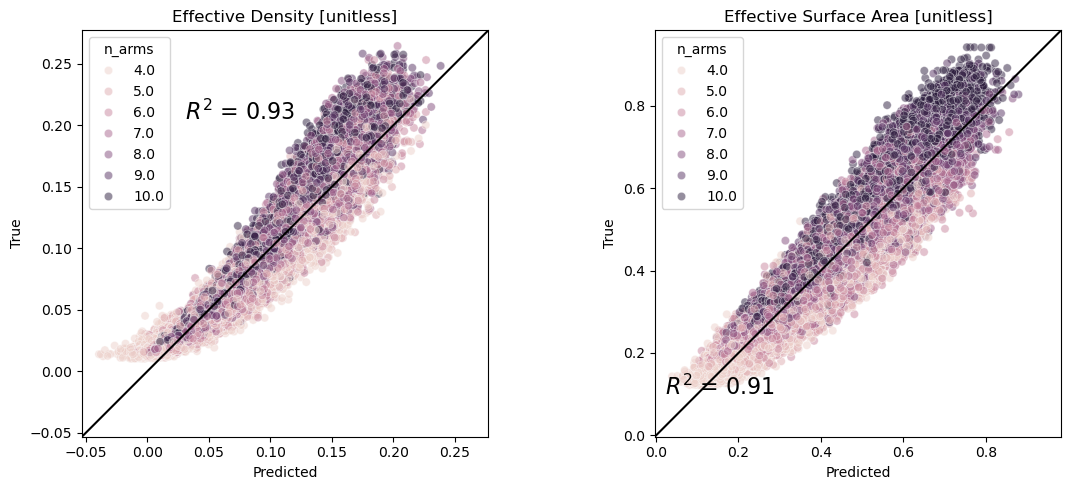

In [6]:
# Sample a subset of the data
df_subset = df_val_out.sample(100_000, random_state=n_rand)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

# Plot for rho_eff
sns.scatterplot(
    data=df_subset, x='rho_eff_pred', y='rho_eff_truth', 
    hue='n_arms', alpha=0.5, legend='full', edgecolor='white', ax=axes[0]
)
lims_rho = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]
axes[0].axline(xy1=(0, 0), slope=1, color='black')
axes[0].set_xlim(lims_rho[0], lims_rho[1])
axes[0].set_ylim(lims_rho[0], lims_rho[1])
axes[0].set_aspect('equal')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')
axes[0].set_title('Effective Density [unitless]')
axes[0].text(0.2, 0.75, f'$R^2$ = {r2_rho:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Plot for sa_eff
sns.scatterplot(
    data=df_subset, x='sa_eff_pred', y='sa_eff_truth', 
    hue='n_arms', alpha=0.5, legend='full', edgecolor='white', ax=axes[1]
)
lims_sa = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]
axes[1].axline(xy1=(0, 0), slope=1, color='black')
axes[1].set_xlim(lims_sa[0], lims_sa[1])
axes[1].set_ylim(lims_sa[0], lims_sa[1])
axes[1].set_aspect('equal')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')
axes[1].set_title('Effective Surface Area [unitless]')
axes[1].text(0.6, 0.2, f'$R^2$ = {r2_sa:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


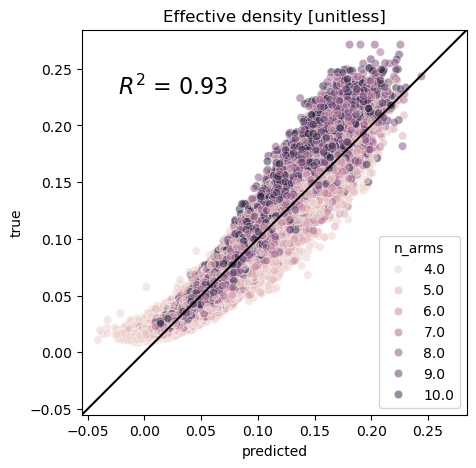

In [8]:
# plot
df_subset = df_val_out.sample(100_000, random_state=n_rand)
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_subset, x='rho_eff_pred', y='rho_eff_truth', 
hue='n_arms', alpha=0.5,
legend='full', edgecolor='white')
# sns.scatterplot(data=df_subset, x='rho_pred', y='rho_truth', 
# size='n_arms', alpha=0.5, palette=mpl.colormaps['plasma'], 
# legend='full')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('true')
ax.set_xlabel('predicted')
ax.set_title('Effective density [unitless]')
ax.text(0.2, 0.75, f'$R^2$ = {r2_rho:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

In [9]:
# # Find the outliers for n_arms=4
# df_4 = df_val_out[df_val_out['n_arms']==4].copy()
# df_4['error_rho_eff'] = np.abs(df_4['rho_eff_truth'] - df_4['rho_eff_pred']) # absolute error
# # order by error
# top_filenames = df_4.nlargest(100, 'error_rho_eff')[['filename', 'error_rho_eff']]
# # save filenames as text file
# save_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/projections'
# file_root = os.path.join(save_dir, 'default', '4')
# save_filename = 'n_arms_4_outliers.txt'
# save_filepath = os.path.join(save_dir, save_filename)
# with open(save_filepath, 'w') as file:
#     for f in top_filenames['filename']:
#         filepath = os.path.join(file_root, f)
#         file.write(f'{filepath}\n')

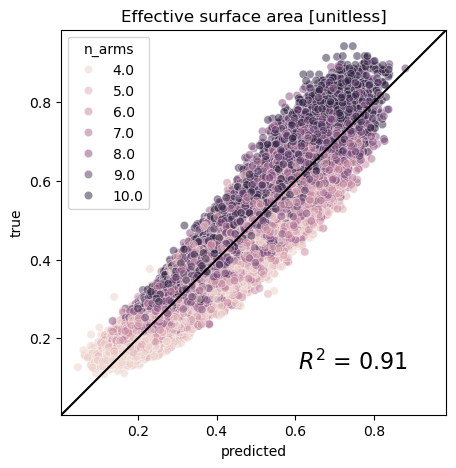

In [10]:
# plot
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_subset, x='sa_eff_pred', y='sa_eff_truth', hue='n_arms', alpha=0.5, legend='full')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('true')
ax.set_xlabel('predicted')
ax.set_title('Effective surface area [unitless]')
ax.text(0.6, 0.2, f'$R^2$ = {r2_sa:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

## n_arms

In [14]:
# create train/test set
df = pd.read_parquet(data_path)
df = df[df['view']=='default']
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
targets = ['n_arms']
# df = df.sample(700_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))

7000000 7000000


In [15]:
# First: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=n_rand)
# Second: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=n_rand)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# train logistic regression
linear_classifier = LogisticRegression(solver='saga', random_state=n_rand, max_iter=1000, n_jobs=16)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
linear_classifier.fit(X_train_scaled, y_train.values.ravel())

LogisticRegression(max_iter=1000, n_jobs=16, random_state=666, solver='saga')

In [17]:
# run model on val data
y_val_pred = linear_classifier.predict(X_val_scaled)

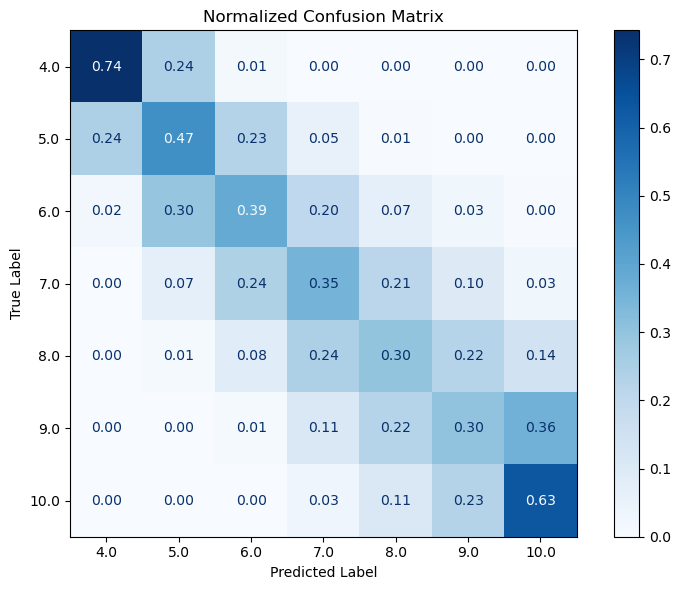

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# Extract predictions and targets
preds = y_val_pred
targets = y_val.values.ravel()

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = linear_classifier.classes_.astype(str)  # Get class labels from the classifier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# RF

## rho_eff

In [11]:
# use cross-validation for random forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=n_rand)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(700000, 8)
(700000, 2)
(6300000, 8)
(6300000, 2)


In [13]:
import psutil
# print(psutil.cpu_count(logical=True))     # Logical cores 
# print(psutil.cpu_count(logical=False))    # Physical cores 
len(psutil.Process().cpu_affinity())   # List of cores this process is allowed to use

18

In [15]:
%%time
# train 
# RandomForestRegressor(max_depth=20, min_samples_leaf=10, n_estimators=200,n_jobs=62, random_state=666)
rf = RandomForestRegressor(max_depth=20, min_samples_leaf=10, n_estimators=200, random_state=n_rand, n_jobs=18)
rf.fit(X_train, y_train)

# run model on val data
y_val_pred_rf = rf.predict(X_val)

CPU times: user 26min 28s, sys: 995 ms, total: 26min 29s
Wall time: 1min 32s


In [36]:
%%time
# Define the model
model = RandomForestRegressor(random_state=n_rand, n_jobs=62)
# Set up hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # for regression
    n_jobs=1,
    verbose=3
)
print(grid_search)
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=62, random_state=666),
             n_jobs=1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=3)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.001 total time=  16.6s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.001 total time=  14.7s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.001 total time=  16.2s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.001 total time=  16.5s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2,

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=62, random_state=666),
             n_jobs=1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=3)

In [37]:
best_model = grid_search.best_estimator_
print(best_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': 62, 'oob_score': False, 'random_state': 666, 'verbose': 0, 'warm_start': False}


In [63]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

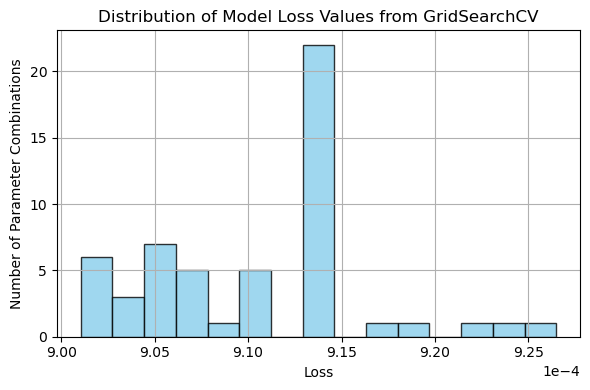

In [64]:
# Assuming you have already run GridSearchCV and saved the results
results_df = pd.DataFrame(grid_search.cv_results_)

# If using a loss metric like neg_mean_squared_error, convert to positive loss values
loss_values = -results_df['mean_test_score']

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the histogram
ax.hist(loss_values, bins=15, color='skyblue', edgecolor='black', alpha=0.8)

# Apply scientific notation to the x-axis
ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))

# Add labels and title
ax.set_title('Distribution of Model Loss Values from GridSearchCV')
ax.set_xlabel('Loss')
ax.set_ylabel('Number of Parameter Combinations')

# Show grid and plot
ax.grid(True)
plt.tight_layout()
plt.show()

In [79]:
# run model on subset of training data (we call it "val" here)
X_temp, X_val, y_temp, y_val = train_test_split(X_test, y_test, test_size=0.20, random_state=n_rand) # get random 20% of training data for "validation"
rf = best_model
y_val_pred_rf = rf.predict(X_val)

In [80]:
X_val.shape

(1260000, 8)

R2 value for effective density: 0.9515058741682051


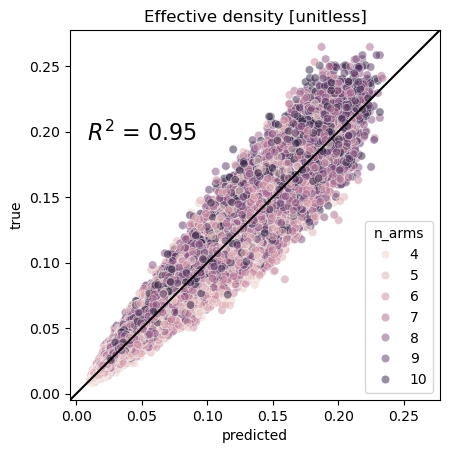

In [16]:
# create output dataframe
df_val_out_rf = y_val.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_val_out_rf['n_arms'] = df['n_arms'].iloc[X_val.index]
df_val_out_rf['rho_eff_pred'] = y_val_pred_rf[:, 0]
df_val_out_rf['sa_eff_pred'] = y_val_pred_rf[:, 1]

df_rf_subset = df_val_out_rf.sample(100_000)
# r2 value
r2 = r2_score(df_val_out_rf['rho_eff_pred'], df_val_out_rf['rho_eff_truth'])
print(f'R2 value for effective density: {r2}')

# plot scatter
fig, ax = plt.subplots()
sns.scatterplot(data=df_rf_subset, x='rho_eff_pred', y='rho_eff_truth', hue='n_arms', alpha=0.5)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('true')
ax.set_xlabel('predicted')
ax.set_title('Effective density [unitless]')
ax.text(0.25, 0.65, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

R2 value for effective density: 0.9515058741682051


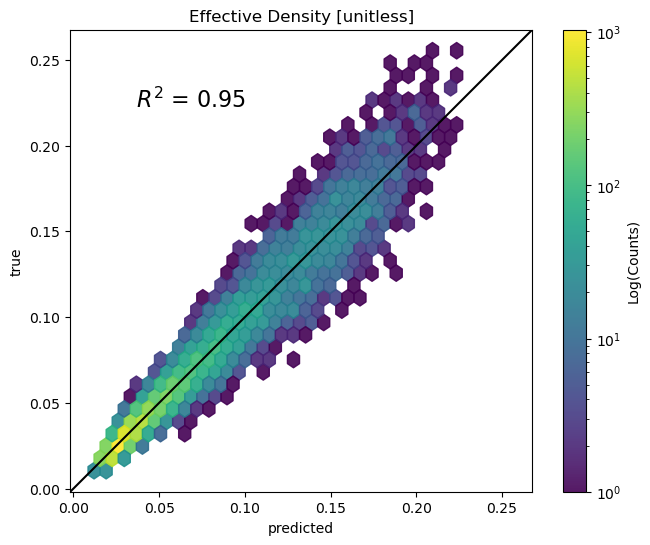

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Create output dataframe
df_val_out_rf = y_val.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_val_out_rf['n_arms'] = df['n_arms'].iloc[X_val.index]
df_val_out_rf['rho_eff_pred'] = y_val_pred_rf[:, 0]
df_val_out_rf['sa_eff_pred'] = y_val_pred_rf[:, 1]

df_rf_subset = df_val_out_rf.sample(10_000)

# R2 value
r2 = r2_score(df_val_out_rf['rho_eff_pred'], df_val_out_rf['rho_eff_truth'])
print(f'R2 value for effective density: {r2}')

# Plot hexbin density plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create hexbin plot
hb = ax.hexbin(df_rf_subset['rho_eff_pred'], df_rf_subset['rho_eff_truth'], gridsize=30, 
               cmap='viridis', mincnt=1, alpha=0.9, bins='log')

# Add colorbar
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Log(Counts)')

# Plot the identity line (the line where predicted equals truth)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline(xy1=(0, 0), slope=1, color='black')

# Set axis limits and labels
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('true')
ax.set_xlabel('predicted')
ax.set_title('Effective Density [unitless]')

# Add R2 text annotation in relative figure coordinates
ax.text(0.25, 0.75, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Show the plot
plt.show()


## sa_eff

R2 value for effective surface area: 0.9158479741899107


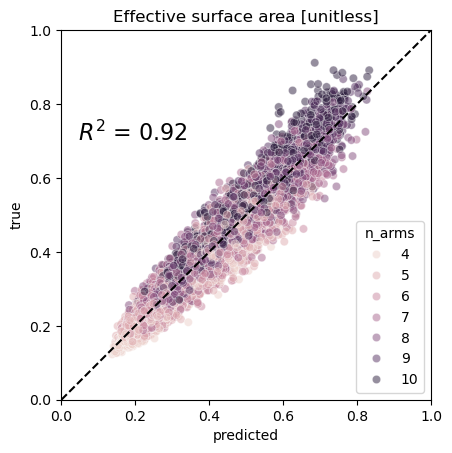

In [18]:
# r2 value
r2 = r2_score(df_val_out_rf['sa_eff_pred'], df_val_out_rf['sa_eff_truth'])
print(f'R2 value for effective surface area: {r2}')

# plot scatter
fig, ax = plt.subplots()
sns.scatterplot(data=df_rf_subset, x='sa_eff_pred', y='sa_eff_truth', hue='n_arms', alpha=0.5)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
min_val, max_val = np.floor(lims[0]), np.ceil(lims[1])
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black', linestyle='--')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_xticks(np.linspace(min_val, max_val, 6))
ax.set_yticks(np.linspace(min_val, max_val, 6))
ax.set_aspect('equal', adjustable='box')
ax.set_ylabel('true')
ax.set_xlabel('predicted')
ax.set_title('Effective surface area [unitless]')
ax.text(0.25, 0.65, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

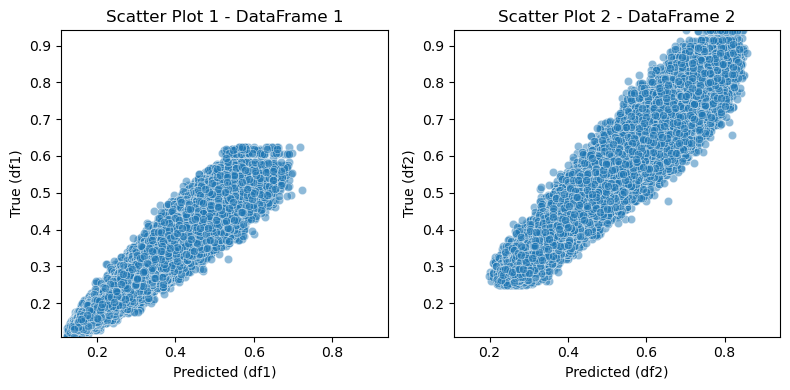

In [19]:
# condition on n_arms
df_4 = df_val_out_rf[df_val_out_rf['n_arms']==4]
df_10 = df_val_out_rf[df_val_out_rf['n_arms']==10]
# Create two subplots side by side (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize as needed

# Get the min and max values across both DataFrames
min_val = np.min([df_4[['sa_eff_pred', 'sa_eff_truth']].min().min(), df_10[['sa_eff_pred', 'sa_eff_truth']].min().min()])
max_val = np.max([df_4[['sa_eff_pred', 'sa_eff_truth']].max().max(), df_10[['sa_eff_pred', 'sa_eff_truth']].max().max()])

# First scatter plot (using df1)
sns.scatterplot(data=df_4, x='sa_eff_pred', y='sa_eff_truth', ax=ax1, alpha=0.5)
ax1.set_title('Scatter Plot 1 - DataFrame 1')
ax1.set_xlabel('Predicted (df1)')
ax1.set_ylabel('True (df1)')

# Second scatter plot (using df2)
sns.scatterplot(data=df_10, x='sa_eff_pred', y='sa_eff_truth', ax=ax2, alpha=0.5)
ax2.set_title('Scatter Plot 2 - DataFrame 2')
ax2.set_xlabel('Predicted (df2)')
ax2.set_ylabel('True (df2)')

# Set the same x and y limits for both subplots
ax1.set_xlim(min_val, max_val)
ax1.set_ylim(min_val, max_val)
ax2.set_xlim(min_val, max_val)
ax2.set_ylim(min_val, max_val)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

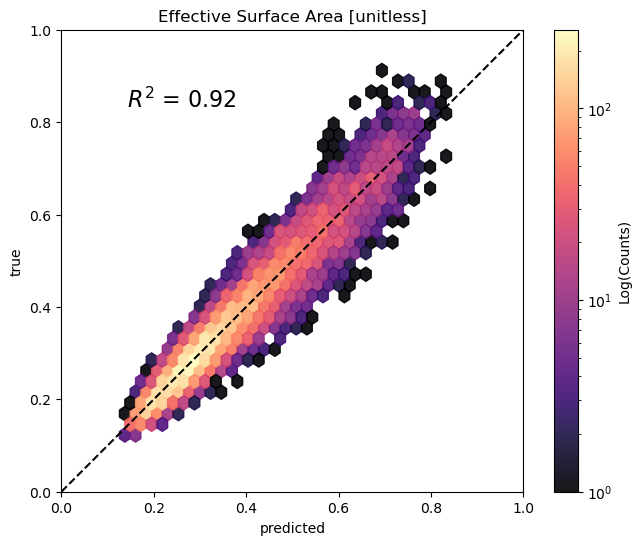

In [20]:
# Plot hexbin density plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create hexbin plot
hb = ax.hexbin(df_rf_subset['sa_eff_pred'], df_rf_subset['sa_eff_truth'], gridsize=30, 
               cmap='magma', mincnt=1, alpha=0.9, bins='log')

# Add colorbar
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Log(Counts)')

# Plot the identity line (the line where predicted equals truth)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
min_val, max_val = np.floor(lims[0]), np.ceil(lims[1])
ax.axline(xy1=(0,0), slope=1, color='black', linestyle='--')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_xticks(np.linspace(min_val, max_val, 6))
ax.set_yticks(np.linspace(min_val, max_val, 6))
ax.set_aspect('equal', adjustable='box')
ax.set_aspect('equal')
ax.set_ylabel('true')
ax.set_xlabel('predicted')
ax.set_title('Effective Surface Area [unitless]')

# Add R2 text annotation in relative figure coordinates
ax.text(0.25, 0.75, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Show the plot
plt.show()


## n_arms

In [20]:
# create train/test set
df = pd.read_parquet(data_path)
df = df[df['view']=='default']
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
targets = ['n_arms']
df = df.sample(700_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))

700000 700000


In [21]:
# First: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=n_rand)
# Second: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=n_rand)

In [26]:
%%time
# Define the model
model = RandomForestClassifier(random_state=n_rand, n_jobs=16)
# Set up hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='accuracy',  # for classification
    n_jobs=1,
    verbose=3
)
print(grid_search)
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=16, random_state=666),
             n_jobs=1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=3)
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.441 total time=  10.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.443 total time=  10.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.443 total time=  10.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.443 total time=  10.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.444 total time=  10.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.443 total time=  20.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.446 total time=  18.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.446 total time=  19.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.446 total time=  18.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.446 total time=  18.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.445 total time=  10.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.447 total time=  10.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.448 total time=  10.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.448 total time=  10.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.447 total time=   9.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.446 total time=  18.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.450 total time=  18.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.449 total time=  19.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.451 total time=  19.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.450 total time=  18.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.447 total time=   9.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.451 total time=   9.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.453 total time=   9.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.452 total time=   9.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.451 total time=   9.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.449 total time=  18.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.452 total time=  18.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.454 total time=  18.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.454 total time=  18.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.452 total time=  18.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.453 total time=   8.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.452 total time=   8.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.455 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.455 total time=   9.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.454 total time=   9.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.453 total time=  17.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.454 total time=  17.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.456 total time=  17.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.456 total time=  16.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.455 total time=  16.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.453 total time=   9.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.452 total time=   9.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.455 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.455 total time=   8.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.454 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.453 total time=  17.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.454 total time=  16.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.456 total time=  17.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.456 total time=  16.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.455 total time=  16.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.453 total time=   9.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.452 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.455 total time=   9.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.455 total time=   9.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.454 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.453 total time=  17.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.454 total time=  17.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.456 total time=  17.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.456 total time=  16.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.455 total time=  17.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.455 total time=   8.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.457 total time=   8.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.458 total time=   8.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.460 total time=   8.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.458 total time=   8.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.456 total time=  15.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.458 total time=  15.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.458 total time=  16.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.460 total time=  15.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.459 total time=  15.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.455 total time=   8.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.457 total time=   8.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.458 total time=   8.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.460 total time=   8.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.458 total time=   8.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.456 total time=  15.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.458 total time=  15.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.458 total time=  15.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.460 total time=  15.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.459 total time=  16.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.455 total time=   8.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.457 total time=   8.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.458 total time=   8.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.460 total time=   8.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.458 total time=   8.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.456 total time=  16.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.458 total time=  15.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.458 total time=  16.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.460 total time=  16.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.459 total time=  15.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.458 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.458 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.463 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.459 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.461 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.459 total time=  11.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.458 total time=  11.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.464 total time=  11.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.460 total time=  11.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.461 total time=  11.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.459 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.458 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.464 total time=   6.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.460 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.461 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.460 total time=  11.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.459 total time=  11.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.464 total time=  11.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.461 total time=  11.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.461 total time=  11.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.458 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.458 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.463 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.460 total time=   5.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.460 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.459 total time=  11.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.458 total time=  10.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.463 total time=  11.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.460 total time=  11.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.461 total time=  11.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.459 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.458 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.463 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.460 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.461 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.459 total time=  11.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.459 total time=  11.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.463 total time=  11.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.460 total time=  11.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.461 total time=  11.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.459 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.458 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.463 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.460 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.461 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.459 total time=  11.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.459 total time=  11.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.463 total time=  11.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.460 total time=  11.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.461 total time=  11.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.459 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.458 total time=   5.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.463 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.460 total time=   5.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.461 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.459 total time=  11.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.459 total time=  11.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.463 total time=  11.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.460 total time=  11.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.461 total time=  11.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.459 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.458 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.462 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.460 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.461 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.459 total time=  11.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.459 total time=  11.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.463 total time=  11.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.460 total time=  11.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.461 total time=  11.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.459 total time=   6.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.458 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.462 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.460 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.461 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.459 total time=  11.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.459 total time=  11.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.463 total time=  11.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.460 total time=  11.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.461 total time=  11.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.459 total time=   6.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.458 total time=   5.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.462 total time=   6.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.460 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.461 total time=   5.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.459 total time=  11.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.459 total time=  11.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.463 total time=  11.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.460 total time=  11.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.461 total time=  11.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.452 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.454 total time=   9.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.455 total time=   9.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.454 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.452 total time=   9.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.455 total time=  17.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.455 total time=  17.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.456 total time=  17.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.456 total time=  17.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.455 total time=  16.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.452 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.454 total time=   8.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.455 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.456 total time=   9.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.456 total time=   8.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.454 total time=  17.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.457 total time=  16.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.457 total time=  17.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.457 total time=  17.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.457 total time=  17.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.454 total time=   9.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.454 total time=   9.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.457 total time=   9.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.457 total time=   8.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.456 total time=   8.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.455 total time=  17.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.456 total time=  16.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.457 total time=  16.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.458 total time=  16.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.457 total time=  16.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.453 total time=   8.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.456 total time=   8.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.458 total time=   8.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.459 total time=   8.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.456 total time=   8.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.455 total time=  16.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.457 total time=  16.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.458 total time=  16.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.458 total time=  16.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.458 total time=  16.1s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.453 total time=   8.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.456 total time=   8.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.458 total time=   8.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.459 total time=   8.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.456 total time=   8.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.455 total time=  16.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.457 total time=  16.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.458 total time=  16.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.458 total time=  16.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=0.458 total time=  16.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.453 total time=   8.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.456 total time=   8.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.458 total time=   8.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.459 total time=   8.7s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.456 total time=   8.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.455 total time=  16.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.457 total time=  16.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.458 total time=  16.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.458 total time=  16.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.458 total time=  16.0s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.456 total time=   8.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.460 total time=   8.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.460 total time=   8.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.460 total time=   8.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=0.459 total time=   8.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.457 total time=  15.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.460 total time=  15.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.460 total time=  15.9s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.462 total time=  15.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=0.459 total time=  15.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.456 total time=   8.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.460 total time=   8.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.460 total time=   8.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.460 total time=   8.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.459 total time=   8.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.457 total time=  15.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.460 total time=  15.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.460 total time=  15.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.462 total time=  15.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=0.459 total time=  15.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.456 total time=   8.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.460 total time=   8.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.460 total time=   8.2s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.460 total time=   8.3s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.459 total time=   8.4s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.457 total time=  15.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.460 total time=  15.8s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.460 total time=  15.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.462 total time=  15.5s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=200;, score=0.459 total time=  15.6s


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CPU times: user 12h 52min 30s, sys: 1min 58s, total: 12h 54min 29s
Wall time: 51min 46s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=16, random_state=666),
             n_jobs=1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=3)

In [28]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)
print("Best estimator:", grid_search.best_estimator_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.46070204081632654
Best estimator: RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       n_jobs=16, random_state=666)


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}  
Best cross-validation accuracy: 0.46070204081632654  
Best estimator: RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       n_jobs=16, random_state=666)  

In [29]:
# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200, random_state=n_rand, n_jobs=16)
rf_classifier.fit(X_train, y_train.values.ravel())

# Print a confirmation message
print("Random Forest Classifier trained successfully.")

Random Forest Classifier trained successfully.


In [30]:
# run model on val data
y_val_pred = rf_classifier.predict(X_val)

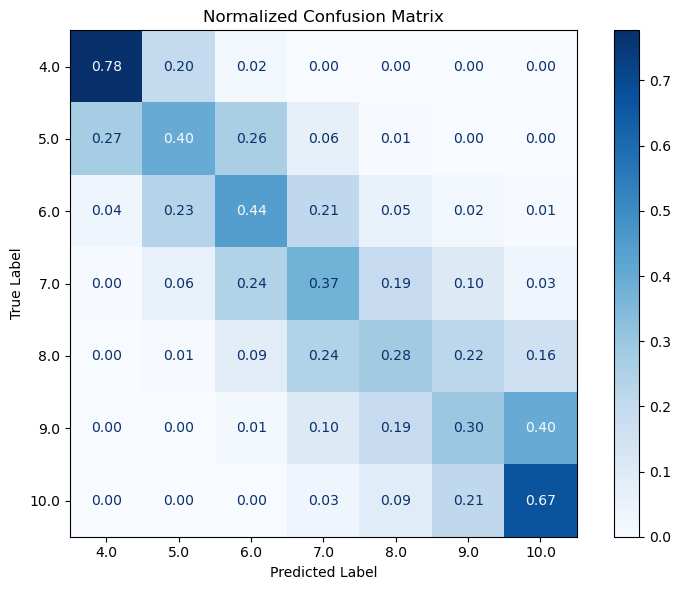

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# Extract predictions and targets
preds = y_val_pred
targets = y_val.values.ravel()

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = linear_classifier.classes_.astype(str)  # Get class labels from the classifier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Stereo

## 2DS

### Regression

In [ ]:
# create train/test set
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/tabular-data-v2'
data_path = 'ros-tabular-data-stereo-default-2ds.parquet'
df = pd.read_parquet(os.path.join(data_dir, data_path))
views = ['default', '2ds']
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
features = [f'{feature}_{view}' for feature in features for view in views]
print(features)
targets = ['rho_eff', 'sa_eff']
# df = df.sample(700_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))

['aspect_ratio_default', 'aspect_ratio_2ds', 'aspect_ratio_elip_default', 'aspect_ratio_elip_2ds', 'extreme_pts_default', 'extreme_pts_2ds', 'contour_area_default', 'contour_area_2ds', 'contour_perimeter_default', 'contour_perimeter_2ds', 'area_ratio_default', 'area_ratio_2ds', 'complexity_default', 'complexity_2ds', 'circularity_default', 'circularity_2ds']
7000000 7000000
(7000000, 20)


In [7]:
n_rand = 666 # random seed
# First: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=n_rand)
# Second: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=n_rand)
# train
reg = LinearRegression()
reg.fit(X_train, y_train)
# run model on val data
y_val_pred = reg.predict(X_val)

In [9]:
# create output dataframe
df_val_out = y_val.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_val_out['n_arms'] = df['n_arms'].iloc[X_val.index]
df_val_out['rho_eff_pred'] = y_val_pred[:, 0]
df_val_out['sa_eff_pred'] = y_val_pred[:, 1]

# get score
r2_rho = r2_score(df_val_out['rho_eff_truth'], df_val_out['rho_eff_pred'])
r2_sa = r2_score(df_val_out['sa_eff_truth'], df_val_out['sa_eff_pred'])
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

R2 for effective density = 0.953905643745157
R2 for effective surface area = 0.9483439478094188


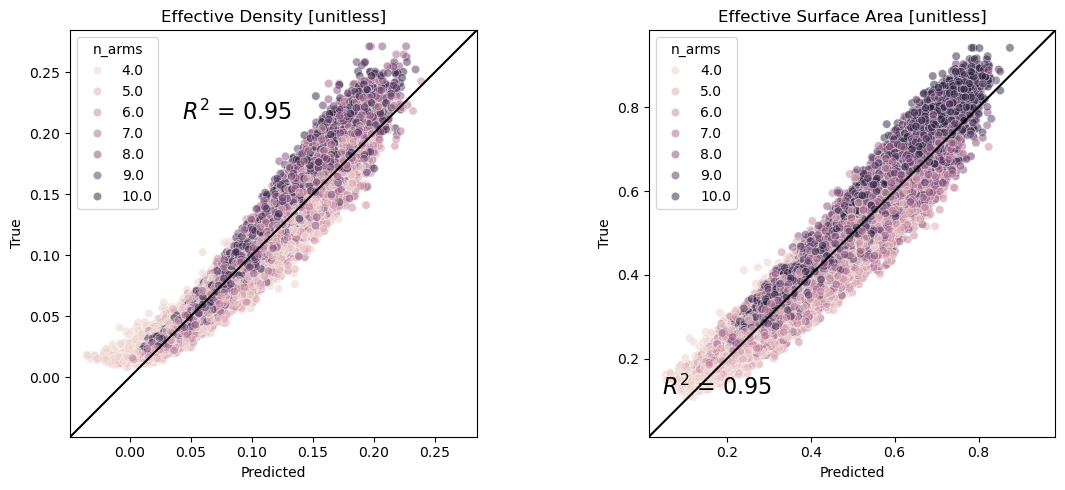

In [ ]:
# Sample a subset of the data
df_subset = df_val_out.sample(100_000, random_state=n_rand)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

# Plot for rho_eff
sns.scatterplot(
    data=df_subset, x='rho_eff_pred', y='rho_eff_truth', 
    hue='n_arms', alpha=0.5, legend='full', edgecolor='white', ax=axes[0]
)
lims_rho = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]
axes[0].axline(xy1=(0, 0), slope=1, color='black')
axes[0].set_xlim(lims_rho[0], lims_rho[1])
axes[0].set_ylim(lims_rho[0], lims_rho[1])
axes[0].set_aspect('equal')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')
axes[0].set_title('Effective Density [unitless]')
axes[0].text(0.2, 0.75, f'$R^2$ = {r2_rho:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Plot for sa_eff
sns.scatterplot(
    data=df_subset, x='sa_eff_pred', y='sa_eff_truth', 
    hue='n_arms', alpha=0.5, legend='full', edgecolor='white', ax=axes[1]
)
lims_sa = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]
axes[1].axline(xy1=(0, 0), slope=1, color='black')
axes[1].set_xlim(lims_sa[0], lims_sa[1])
axes[1].set_ylim(lims_sa[0], lims_sa[1])
axes[1].set_aspect('equal')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')
axes[1].set_title('Effective Surface Area [unitless]')
axes[1].text(0.6, 0.2, f'$R^2$ = {r2_sa:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Classification

In [13]:
# create train/test set
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/tabular-data-v2'
data_path = 'ros-tabular-data-stereo-default-2ds.parquet'
df = pd.read_parquet(os.path.join(data_dir, data_path))
views = ['default', '2ds']
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
features = [f'{feature}_{view}' for feature in features for view in views]
print(features)
targets = ['n_arms']
# df = df.sample(700_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))
# First: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=n_rand)
# Second: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=n_rand)

['aspect_ratio_default', 'aspect_ratio_2ds', 'aspect_ratio_elip_default', 'aspect_ratio_elip_2ds', 'extreme_pts_default', 'extreme_pts_2ds', 'contour_area_default', 'contour_area_2ds', 'contour_perimeter_default', 'contour_perimeter_2ds', 'area_ratio_default', 'area_ratio_2ds', 'complexity_default', 'complexity_2ds', 'circularity_default', 'circularity_2ds']
7000000 7000000


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# train logistic regression
linear_classifier = LogisticRegression(solver='saga', random_state=n_rand, max_iter=1000, n_jobs=16)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
linear_classifier.fit(X_train_scaled, y_train.values.ravel())

LogisticRegression(max_iter=1000, n_jobs=16, random_state=666, solver='saga')

In [15]:
# run model on val data
y_val_pred = linear_classifier.predict(X_val_scaled)

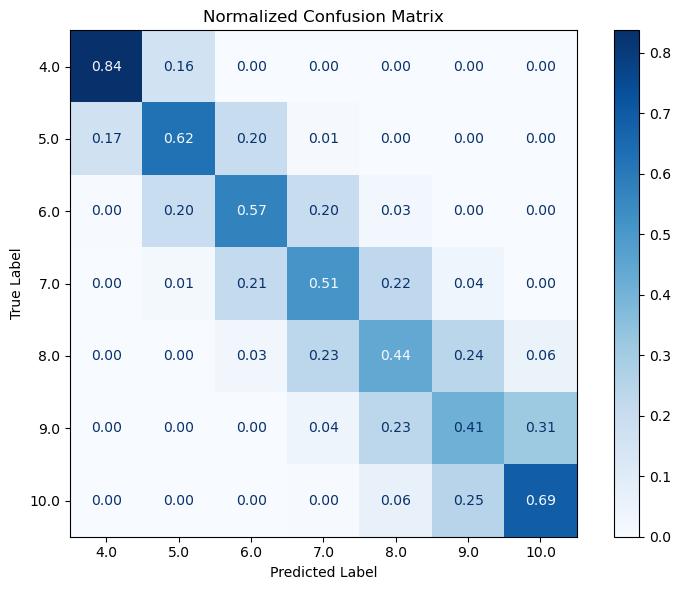

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# Extract predictions and targets
preds = y_val_pred
targets = y_val.values.ravel()

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = linear_classifier.classes_.astype(str)  # Get class labels from the classifier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## PHIPS

### Regression

In [9]:
# create train/test set
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/tabular-data-v2'
data_path = 'ros-tabular-data-stereo-default-phips.parquet'
df = pd.read_parquet(os.path.join(data_dir, data_path))
views = ['default', 'phips']
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
features = [f'{feature}_{view}' for feature in features for view in views]
print(features)
targets = ['rho_eff', 'sa_eff']
# df = df.sample(700_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))

['aspect_ratio_default', 'aspect_ratio_phips', 'aspect_ratio_elip_default', 'aspect_ratio_elip_phips', 'extreme_pts_default', 'extreme_pts_phips', 'contour_area_default', 'contour_area_phips', 'contour_perimeter_default', 'contour_perimeter_phips', 'area_ratio_default', 'area_ratio_phips', 'complexity_default', 'complexity_phips', 'circularity_default', 'circularity_phips']
7000000 7000000


In [10]:
n_rand = 666 # random seed
# First: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=n_rand)
# Second: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=n_rand)
# train
reg = LinearRegression()
reg.fit(X_train, y_train)
# run model on val data
y_val_pred = reg.predict(X_val)

In [11]:
# create output dataframe
df_val_out = y_val.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_val_out['n_arms'] = df['n_arms'].iloc[X_val.index]
df_val_out['rho_eff_pred'] = y_val_pred[:, 0]
df_val_out['sa_eff_pred'] = y_val_pred[:, 1]

# get score
r2_rho = r2_score(df_val_out['rho_eff_truth'], df_val_out['rho_eff_pred'])
r2_sa = r2_score(df_val_out['sa_eff_truth'], df_val_out['sa_eff_pred'])
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

R2 for effective density = 0.952193774474097
R2 for effective surface area = 0.9450298260095212


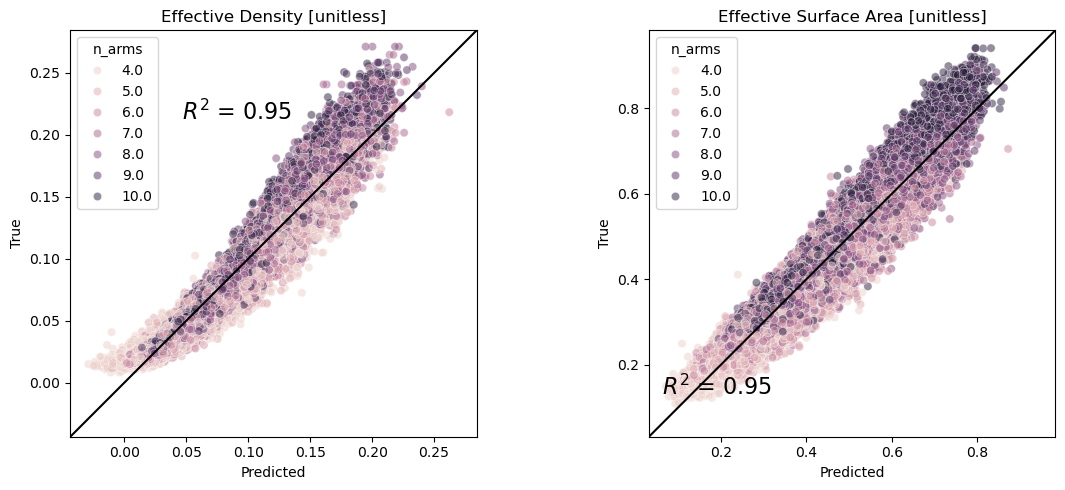

In [12]:
# Sample a subset of the data
df_subset = df_val_out.sample(100_000, random_state=n_rand)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

# Plot for rho_eff
sns.scatterplot(
    data=df_subset, x='rho_eff_pred', y='rho_eff_truth', 
    hue='n_arms', alpha=0.5, legend='full', edgecolor='white', ax=axes[0]
)
lims_rho = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]
axes[0].axline(xy1=(0, 0), slope=1, color='black')
axes[0].set_xlim(lims_rho[0], lims_rho[1])
axes[0].set_ylim(lims_rho[0], lims_rho[1])
axes[0].set_aspect('equal')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')
axes[0].set_title('Effective Density [unitless]')
axes[0].text(0.2, 0.75, f'$R^2$ = {r2_rho:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Plot for sa_eff
sns.scatterplot(
    data=df_subset, x='sa_eff_pred', y='sa_eff_truth', 
    hue='n_arms', alpha=0.5, legend='full', edgecolor='white', ax=axes[1]
)
lims_sa = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]
axes[1].axline(xy1=(0, 0), slope=1, color='black')
axes[1].set_xlim(lims_sa[0], lims_sa[1])
axes[1].set_ylim(lims_sa[0], lims_sa[1])
axes[1].set_aspect('equal')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')
axes[1].set_title('Effective Surface Area [unitless]')
axes[1].text(0.6, 0.2, f'$R^2$ = {r2_sa:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Classification

In [13]:
# create train/test set
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/tabular-data-v2'
data_path = 'ros-tabular-data-stereo-default-phips.parquet'
df = pd.read_parquet(os.path.join(data_dir, data_path))
views = ['default', 'phips']
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
features = [f'{feature}_{view}' for feature in features for view in views]
print(features)
targets = ['n_arms']
# df = df.sample(700_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))
# First: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=n_rand)
# Second: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=n_rand)

['aspect_ratio_default', 'aspect_ratio_phips', 'aspect_ratio_elip_default', 'aspect_ratio_elip_phips', 'extreme_pts_default', 'extreme_pts_phips', 'contour_area_default', 'contour_area_phips', 'contour_perimeter_default', 'contour_perimeter_phips', 'area_ratio_default', 'area_ratio_phips', 'complexity_default', 'complexity_phips', 'circularity_default', 'circularity_phips']
7000000 7000000


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# train logistic regression
linear_classifier = LogisticRegression(solver='saga', random_state=n_rand, max_iter=1000, n_jobs=16)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
linear_classifier.fit(X_train_scaled, y_train.values.ravel())

LogisticRegression(max_iter=1000, n_jobs=16, random_state=666, solver='saga')

In [15]:
# run model on val data
y_val_pred = linear_classifier.predict(X_val_scaled)

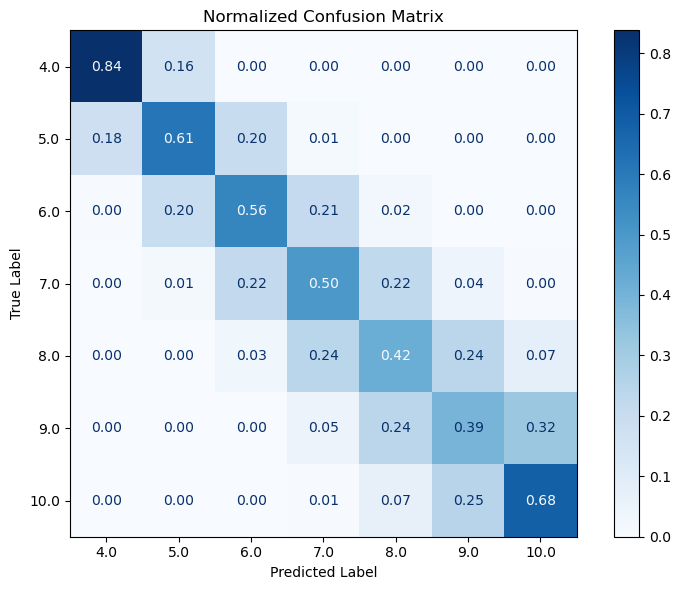

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# Extract predictions and targets
preds = y_val_pred
targets = y_val.values.ravel()

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = linear_classifier.classes_.astype(str)  # Get class labels from the classifier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()